In [21]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../../../../')
import set_plot_sizes

sys.path.append('../../../../../cosmosis_wrappers/') # change to correct path
import ABC_saved_sims_multiparam

from tqdm import tqdm_notebook as tqdm

# change to the path where ABCPMC git clone is located
sys.path.insert(0,'../../../../../../abcpmc/')
import abcpmc # find citation at https://github.com/jakeret/abcpmc

import corner

In [22]:
data_dir = './preloaded_data_sigma8/ABC_results'

In [23]:
# ls

In [24]:
def load_ABC_results(modelversion):
    """
    Load the results of 10,000 simulations that have been fed through a trained network 
    and compared with some fiducial simulation
    """
    abc = dict()
    for key in ['summary', 'fisher', 'parameters', 'summaries', 'differences', 'distances', 'MLE']:
        abc[key] = np.load(f'./preloaded_data_sigma8/ABC_results/abc{modelversion}{key}.npy')
    return abc

In [25]:
abc = load_ABC_results(modelversion=3)

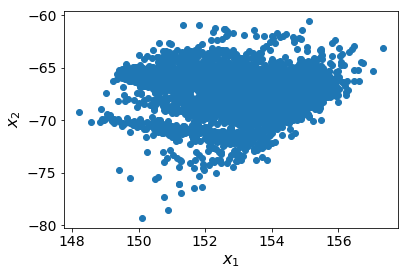

In [26]:
plt.scatter(abc['summaries'][:,0],abc['summaries'][:,1]);
plt.xlabel('$x_1$');
plt.ylabel('$x_2$');
plt.savefig('./output.png')
plt.show()

In [27]:
print (np.corrcoef(abc['summaries'],rowvar=False))

[[ 1.        -0.2900731]
 [-0.2900731  1.       ]]


#### The variables seem negatively correlated quite significantly. Also note the one weird region: (the lower stripe)

#### What if we just load noisy versions of the fiducial cosmology?

In [28]:
# (5000,600). 5000 simulations of flattened noisy fiducial cosmology
fid_sims = np.load('./fid_sims.npy')
# (5000,2) summaries of the flattened noisy fiducial cosmology
fidsummaries = np.load('fid_summaries.npy')

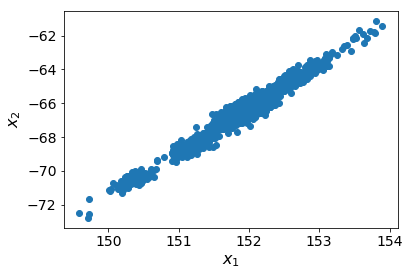

[[1.         0.95541443]
 [0.95541443 1.        ]]


In [29]:
plt.scatter(fidsummaries[:,0],fidsummaries[:,1]);
plt.xlabel('$x_1$');
plt.ylabel('$x_2$');
plt.savefig('./output_fid.png')
plt.show()
print (np.corrcoef(fidsummaries,rowvar=False))

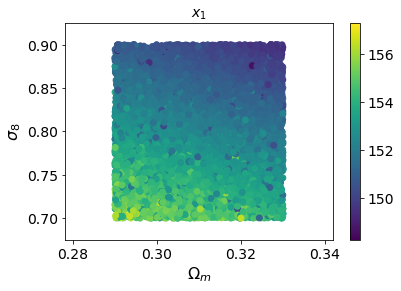

In [30]:
num = 10000 # number of points to plot
plt.scatter(abc['parameters'][:num,0],abc['parameters'][:num,1],c=abc['summaries'][:num,0]);
plt.title("$x_1$")
plt.colorbar()
plt.xlabel('$\Omega_m$');
plt.ylabel('$\sigma_8$')
# plt.legend(frameon=False);
plt.show()

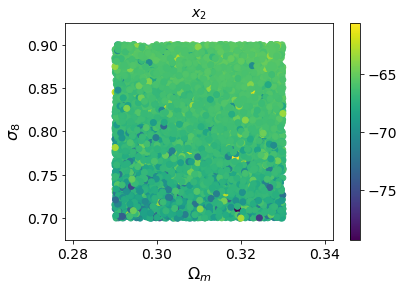

In [31]:
plt.scatter(abc['parameters'][:num,0],abc['parameters'][:num,1],c=abc['summaries'][:num,1]);
plt.title("$x_2$")
plt.colorbar()
plt.xlabel('$\Omega_m$');
plt.ylabel('$\sigma_8$')
# plt.legend(frameon=False);
plt.show()

#### $x_1$ seems to be easier to fit with a plane than $x_2$, we shall start with $x_1 = a\Omega_m + b\sigma_8$.

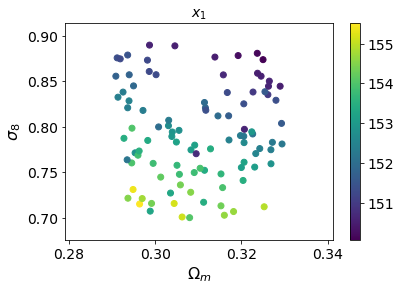

In [32]:
num = 100 # number of points to plot
plt.scatter(abc['parameters'][:num,0],abc['parameters'][:num,1],c=abc['summaries'][:num,0]);
plt.title("$x_1$")
plt.colorbar()
plt.xlabel('$\Omega_m$');
plt.ylabel('$\sigma_8$')
# plt.legend(frameon=False);
plt.show()

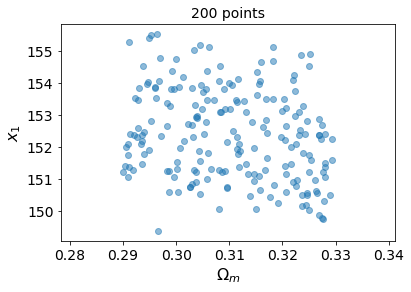

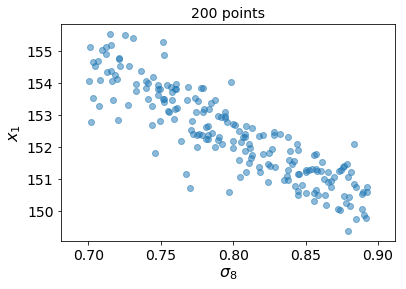

In [33]:
# num = 1000
# plt.title(f"{num} points")
# plt.scatter(abc['parameters'][:num,0], abc['summaries'][:num,0],alpha=0.5)
# plt.xlabel('$\Omega_m$');
# plt.ylabel('$x_1$')
# plt.show()

# plt.title(f"{num} points")
# plt.scatter(abc['parameters'][:num,1], abc['summaries'][:num,0],alpha=0.5)
# plt.xlabel('$\sigma_8$');
# plt.ylabel('$x_1$')
# plt.show()

num = 200
plt.title(f"{num} points")
plt.scatter(abc['parameters'][:num,0], abc['summaries'][:num,0],alpha=0.5)
plt.xlabel('$\Omega_m$');
plt.ylabel('$x_1$')
plt.show()

plt.title(f"{num} points")
plt.scatter(abc['parameters'][:num,1], abc['summaries'][:num,0],alpha=0.5)
plt.xlabel('$\sigma_8$');
plt.ylabel('$x_1$')
plt.show()

In [34]:
def linleastsquares(X, y):
    """
    Fit linear least squares, given a matrix X
    X = shape (observations,num_params) (1000,2)
    y = observed data values -- shape = (1000,)
    
    returns beta -- best fit parameters -- shape (2,)
    """
    beta = np.dot((np.dot( np.linalg.inv(np.dot(X.T,X)), X.T)),y)   
    return beta

In [35]:
def plot_fit_result(model,xindx):
    """
    Plot a few images to show how well the model fits the data
    
    model -- function: the best fit model, should take two parameters: Omega_m and sigma_8
    xindx -- integer:  1 for fitting x1. 2 for fitting x2
    
    """
    # Calculate values according to the model
    omega_m = np.linspace(0.28,0.34,30)
    sigma_8 = np.linspace(0.70,0.90,30)
    xv, yv = np.meshgrid(omega_m, sigma_8)
    model_sol = model(xv,yv)

    plt.contourf(omega_m,sigma_8, model_sol);
    plt.title(f"Fit to $x_{xindx}$")
    plt.colorbar()
    plt.xlabel('$\Omega_m$');
    plt.ylabel('$\sigma_8$')
    # plt.legend(frameon=False);
    plt.show()

    # color boundaries hardcoded
    if xindx == 1:
        vmin = 149
        vmax = 157
    if xindx == 2:
        vmin = -79
        vmax = -61
    
    num = 1000
    model_sol_scatter = model(abc['parameters'][:num,0],abc['parameters'][:num,1])
    plt.scatter(abc['parameters'][:num,0],abc['parameters'][:num,1], c=model_sol_scatter
                ,vmin=vmin,vmax=vmax);
    plt.title(f"Fit to $x_{xindx}$")
    plt.colorbar()
    plt.xlabel('$\Omega_m$');
    plt.ylabel('$\sigma_8$')
    # plt.legend(frameon=False);
    plt.show()

    plt.scatter(abc['parameters'][:num,0],abc['parameters'][:num,1],c=abc['summaries'][:num,xindx-1]
                ,vmin=vmin,vmax=vmax);
    plt.title(f"Actual $x_{xindx}$")
    plt.colorbar()
    plt.xlabel('$\Omega_m$');
    plt.ylabel('$\sigma_8$')
    # plt.legend(frameon=False);
    plt.show()
    
def plot_fit_result1D(model,xindx):
    """
    Plot a few images in 1D to show how well the model fits the data
    
    model -- function: the best fit model, should take two parameters: Omega_m and sigma_8
    xindx -- integer:  1 for fitting x1. 2 for fitting x2
    
    """
    num = 1000
    model_sol_scatter = model(abc['parameters'][:num,0],abc['parameters'][:num,1])
    plt.title(f"{num} points")
    plt.scatter(abc['parameters'][:num,0], model_sol_scatter,alpha=0.5)
    plt.xlabel('$\Omega_m$');
    plt.ylabel(f'$x_{xindx}$')
    plt.show()

    plt.title(f"{num} points")
    plt.scatter(abc['parameters'][:num,1], model_sol_scatter,alpha=0.5)
    plt.xlabel('$\sigma_8$');
    plt.ylabel(f'$x_{xindx}$')
    plt.show()

In [36]:
# Fit to 200 points
num = 200
# Fit x1 = a\Omega_m + b\sigma_8 + c
X = np.array([abc['parameters'][:num,0], abc['parameters'][:num,1], np.ones(num)]).T # (1000,3)
y = abc['summaries'][:num,0] # x1

ahat, bhat, chat = linleastsquares(X,y)
print (ahat,bhat, chat)

-34.111706898950274 -22.986691736333057 181.33919959986176


In [37]:
model = lambda x, y: ahat*x + bhat*y + chat

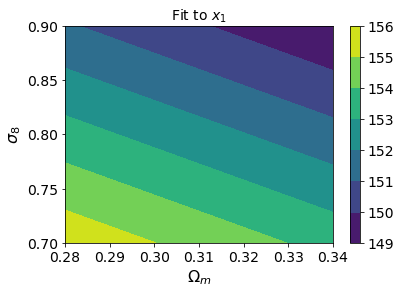

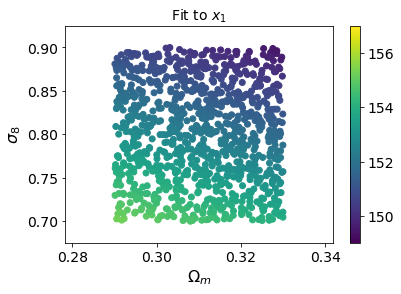

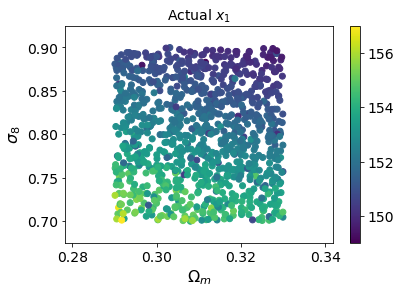

In [38]:
plot_fit_result(model,xindx=1)

#### Imo the fit looks quite good.

In [39]:
# Fit to x2, same procedure

num = 200
# Fit x1 = a\Omega_m + b\sigma_8 + c
X = np.array([abc['parameters'][:num,0], abc['parameters'][:num,1], np.ones(num)]).T # (1000,3)
y2 = abc['summaries'][:num,1] # x2

ahat2, bhat2, chat2 = linleastsquares(X,y2)
print (ahat2,bhat2, chat2)

24.693852408845373 14.539551951223899 -86.13434701648762


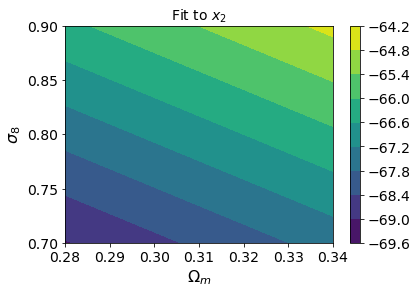

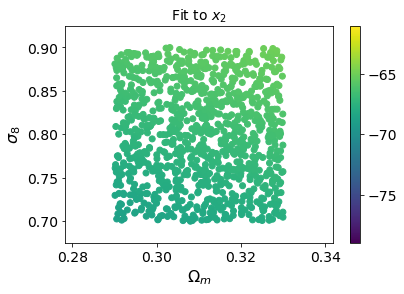

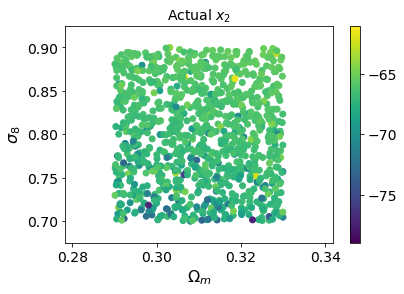

In [40]:
model2 = lambda x, y: ahat2*x + bhat2*y + chat2
plot_fit_result(model2,xindx=2)

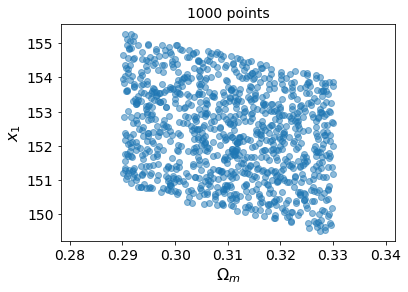

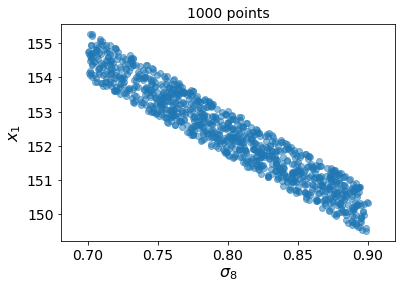

In [41]:
# Now in 1D:
plot_fit_result1D(model,xindx=1)

#### Now perform ABC with the function that generates x1 and x2, no cosmosis needed.

In [43]:
import tensorflow as tf
# change to the path where the IMNN git clone is located
# new version of IMNN by Tom
sys.path.insert(-1,'../../../../../../IMNNv2/IMNN/')
import IMNN.ABC.priors as priors

In [44]:
def output_summaries(theta,model1,model2):
    """
    Return x1,x2 for a given theta = list of [Omega_m, sigma_8]'s' 
    given the two fitted models to x1 x2
    """
    theta = np.array(theta)
    Omega_m = theta[:,0]
    sigma_8 = theta[:,1]
    x1 = model1(Omega_m,sigma_8)
    x2 = model2(Omega_m,sigma_8)
    
    return np.array([x1,x2]).T # return as array of shape (len(theta),2)

In [45]:
def ABC_with_model(draws, real_summary, prior, model1, model2, fisher):

    Gaussprior = priors.TruncatedGaussian(prior["mean"],prior["variance"],prior["lower"]
                                    ,prior["upper"])
    # Draw params from Gaussian prior
    theta = Gaussprior.draw(draws)
    # Calculate summaries with models
    summaries = output_summaries(theta, model1,model2)
    # Calculate distance
    differences = summaries - real_summary
    distances = np.sqrt(
        np.einsum(
            'ij,ij->i',
            differences,
            np.einsum(
                'jk,ik->ij',
                fisher,
                differences)))
    ABC_dict = dict()
    ABC_dict["summary"] = real_summary
    ABC_dict["fisher"] = fisher
    ABC_dict["parameters"] = theta
    ABC_dict["summaries"] = summaries
    ABC_dict["differences"] = differences
    ABC_dict["distances"] = distances
    
    return ABC_dict
    

In [52]:
# Variables for ABC
draws = int(1e5) # amount of draws
fisher = abc['fisher'] # fisher info
real_summary = abc['summary'] # summary of 'real' data
# A Truncated gaussian prior
prior = {'mean': np.array([0.30,0.805]),
         'variance': np.array([[0.01,0],[0,0.01]]), # cov matrix
         'lower': np.array([0.0,0.4]),
         'upper': np.array([1.0,1.2]) 
         }

In [53]:
abc_model = ABC_with_model(draws, real_summary, prior, model, model2, fisher)

Epsilon is chosen to be 80.00
Number of accepted samples =  3261


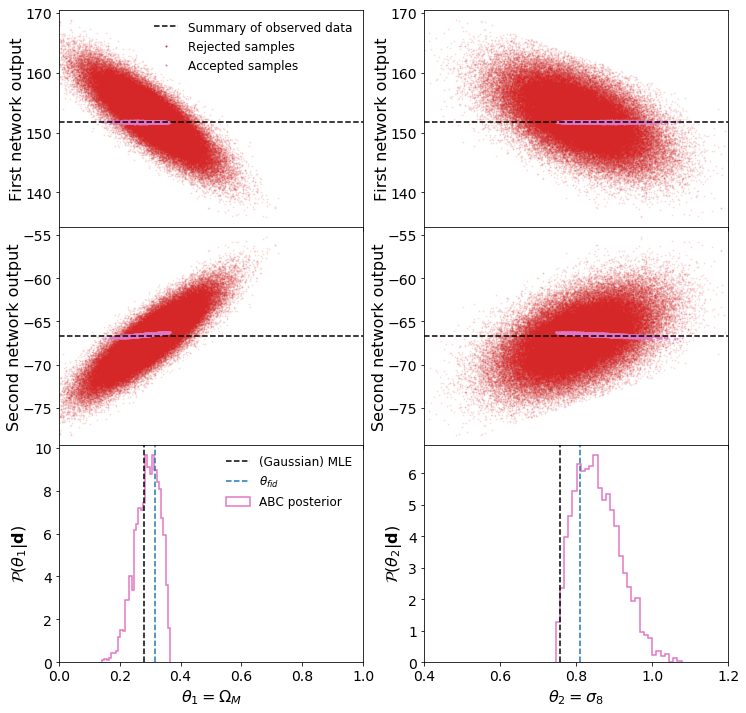

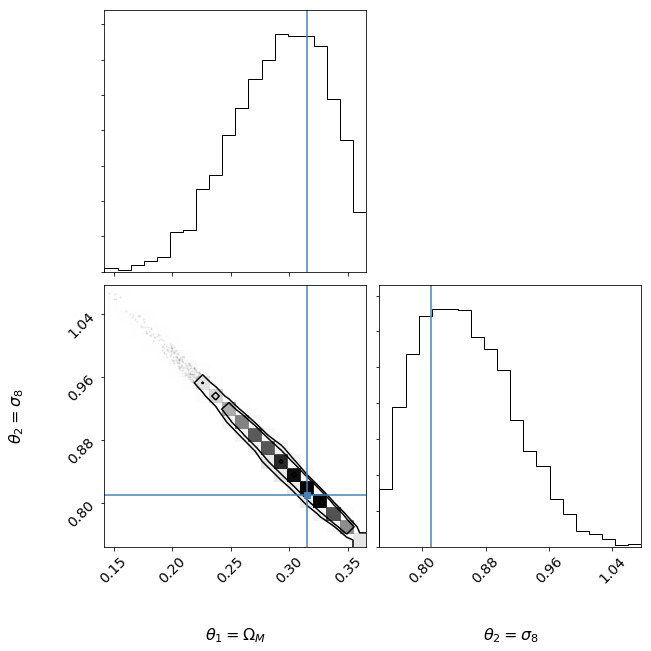

In [54]:
class holder(object):
    """Small class because plotting function requires it"""
    def __init__(self,saveversion,figuredir):
        self.modelversion = saveversion
        self.figuredir = figuredir
        

holder1 = holder(saveversion=3,figuredir='./')
theta_fid = np.array([0.315, 0.811])
# plotting function requires this too, does not depend on model fitting though, so steal from earlier abc
abc_model["MLE"] = abc["MLE"]
ABC_saved_sims_multiparam.plot_ABC_2params(abc_model, holder1, theta_fid, prior, oneD='both'
                                           , hbins=30, epsilon=80,show=True)


In [93]:
from importlib import reload

In [27]:
reload(ABC_saved_sims_multiparam)

<module 'ABC_saved_sims_multiparam' from '../../../../cosmosis_wrappers/ABC_saved_sims_multiparam.py'>

#### Now do ABC-PMC with these models

In [95]:
# Do ABC-PMC
def dist_measure(x,y):
    # Calculate distance
    fisher = abc['fisher']
    
    differences = x - y
    
    distances = np.sqrt(
        np.einsum(
            'ij,ij->i',
            differences,
            np.einsum(
                'jk,ik->ij',
                fisher,
                differences)))
    
    return distances[0]

# def dist_measure(x,y):
#     # do Euclidian distance to start with
    

def PMCoutput_summaries(theta,model1,model2):
    """
    Return x1,x2 for a given theta = list of [Omega_m, sigma_8]'s' 
    given the two fitted models to x1 x2
    """
    # PMC function only generates one particle at a time
    Omega_m = theta[0]
    sigma_8 = theta[1]
    x1 = model1(Omega_m,sigma_8)
    x2 = model2(Omega_m,sigma_8)
    
    return np.array([x1,x2]).T # return as array of shape (len(theta),2)

def pmcfunc(theta):
    """wrapper for PMC moduel"""
    return PMCoutput_summaries(theta,model,model2)

pmcprior = abcpmc.GaussianPrior(mu=prior["mean"]
                                ,sigma=prior["variance"])
alpha = 75 #th percentile of the sorted distances = new epsilon
T = 15 # iterations
eps_start = 200.0 # starting threshold, quite arbitrary
eps = abcpmc.ConstEps(T, eps_start)
# creation of new samples

# create instance of sampler,
sampler = abcpmc.Sampler(N=1000, Y=abc['summary']
                         , postfn=pmcfunc
                         , dist=dist_measure, threads=3)

sampler.particle_proposal_cls = abcpmc.OLCMParticleProposal

distances = [dist_measure(abc['summary'], pmcfunc(thet))
             for thet in abc["parameters"][:100]]


In [96]:
# Now we are ready to sample:
def launch():
    eps = abcpmc.ConstEps(T, eps_start)

    pools = []
    for pool in sampler.sample(pmcprior, eps):
#                      ,desc='eps: {1:>.4f}, ratio: {2:>.4f}'.format(pool.t, eps(pool.eps), pool.ratio)):
        print("T: {0}, eps: {1:>.4f}, ratio: {2:>.4f}".format(pool.t, eps(pool.eps), pool.ratio),)

        
#         for i, (mean, std) in enumerate(zip(*abcpmc.weighted_avg_and_std(pool.thetas, pool.ws, axis=0))):
#             print(u"    theta[{0}]: {1:>.4f} \u00B1 {2:>.4f}".format(i, mean,std))

        eps.eps = np.percentile(pool.dists, alpha) # reduce eps value
        pools.append(pool)
    sampler.close()
    return pools

import time
t0 = time.time()
pools = launch()
print ("took", (time.time() - t0))

T: 0, eps: 200.0000, ratio: 0.1189
T: 1, eps: 150.7248, ratio: 0.6072
T: 2, eps: 113.9313, ratio: 0.6154
T: 3, eps: 89.9758, ratio: 0.5737
T: 4, eps: 72.7685, ratio: 0.5714
T: 5, eps: 58.5082, ratio: 0.5473
T: 6, eps: 47.3270, ratio: 0.5291
T: 7, eps: 36.8752, ratio: 0.5120
T: 8, eps: 29.6183, ratio: 0.5241
T: 9, eps: 23.8386, ratio: 0.5305
T: 10, eps: 19.3188, ratio: 0.5244
T: 11, eps: 15.1663, ratio: 0.5249
T: 12, eps: 11.8657, ratio: 0.5105
T: 13, eps: 9.5993, ratio: 0.5099
T: 14, eps: 7.8239, ratio: 0.5400
took 15.16279673576355


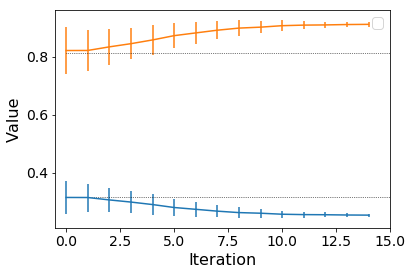

In [97]:
# Postprocessing
for i in range(np.shape(abc['summary'])[1]):
    moments = np.array([abcpmc.weighted_avg_and_std(
        pool.thetas[:,i], pool.ws, axis=0) for pool in pools])
    plt.errorbar(range(T), moments[:, 0], moments[:, 1])
plt.hlines(theta_fid, 0, T, linestyle="dotted", linewidth=0.7)
plt.xlim([-.5, T])
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.legend()
plt.show()


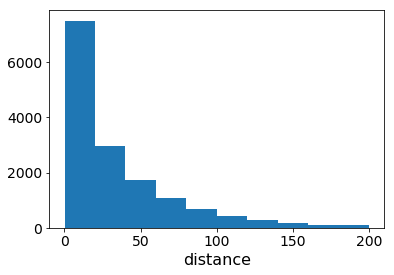

In [102]:
distances = np.array([pool.dists for pool in pools]).flatten()
plt.hist(distances)
plt.xlabel("distance")
plt.show()

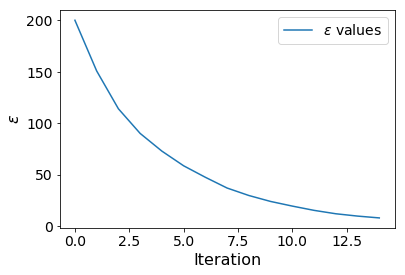

In [103]:
eps_values = np.array([pool.eps for pool in pools])
plt.plot(eps_values, label=r"$\epsilon$ values")
plt.xlabel("Iteration")
plt.ylabel(r"$\epsilon$")
plt.legend(loc="best")

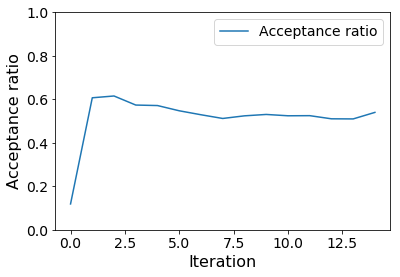

In [104]:
acc_ratios = np.array([pool.ratio for pool in pools])
plt.plot(acc_ratios, label="Acceptance ratio")
plt.ylim([0, 1])
plt.xlabel("Iteration")
plt.ylabel("Acceptance ratio")
plt.legend(loc="best")

(15000, 2)


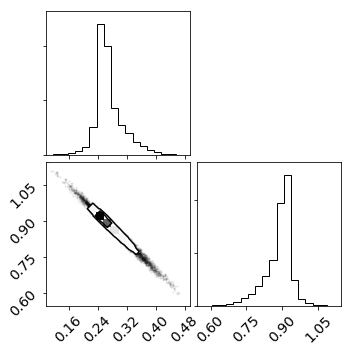

(array([    8,    18,    37, ..., 14995, 14996, 14997]), array([0, 0, 0, ..., 0, 0, 0]))
0.3882415983069938


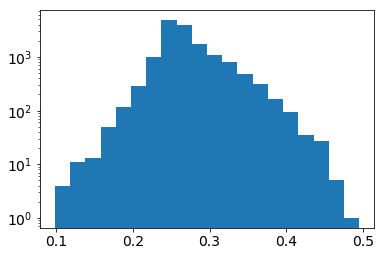

In [106]:
samples = np.vstack([pool.thetas for pool in pools])
print (np.shape(samples))
fig = corner.corner(samples, truths= abc["summary"][0],bins=20)
plt.show()

np.sum((samples > 0.25) & (samples < 0.27))
print (np.where((samples > 0.25) & (samples < 0.27)))
print (samples[2,0])

plt.hist(samples[:,0],bins=20)
plt.yscale('log')
plt.show()

#### What if we just fit a line to a summmary as a function of $\Omega_m$ and as function of $\sigma_8$ seperately? Essentially that is saying 
\begin{equation}
\vec{x} (\Omega_m,\sigma_8) => \vec{x} (\Omega_m),\vec{x} (\sigma_8)
\end{equation}

#### I think the above is already correct, but below is some interesting investigation

In [35]:
# Fit to 200 points
num = 200
# Fit x1 = a11\Omega_m + b11
X = np.array([abc['parameters'][:num,0], np.ones(num)]).T # (1000,2)
y = abc['summaries'][:num,0] # x1

a11hat, b11hat = linleastsquares(X,y)
print (a11hat,b11hat)

# and x2 = a21\Omega_m + b21
X = np.array([abc['parameters'][:num,0], np.ones(num)]).T # (1000,2)
y = abc['summaries'][:num,1] # x2
a21hat, b21hat = linleastsquares(X,y)
print (a21hat,b21hat)

-29.23570211919457 161.46084249888997
21.609679809200884 -73.56088019969843


In [36]:
# x1 as function of Omega_M
model11 = lambda x: a11hat*x+b11hat
# x2 as function of Omega_M
model21 = lambda x: a21hat*x+b21hat

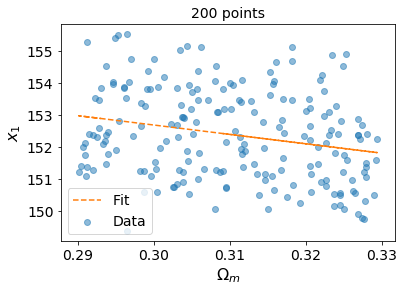

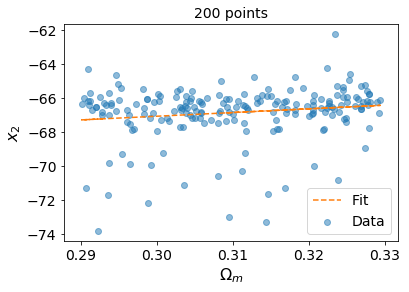

In [37]:
num = 200
plt.plot(abc['parameters'][:num,0], model11(abc['parameters'][:num,0]),label='Fit',ls='dashed',c='C1')
plt.title(f"{num} points")
plt.scatter(abc['parameters'][:num,0], abc['summaries'][:num,0],alpha=0.5,label='Data')
plt.xlabel('$\Omega_m$');
plt.ylabel('$x_1$')
plt.legend()
plt.show()

plt.plot(abc['parameters'][:num,0], model21(abc['parameters'][:num,0]),label='Fit',ls='dashed',c='C1')
plt.title(f"{num} points")
plt.scatter(abc['parameters'][:num,0], abc['summaries'][:num,1],alpha=0.5,label='Data')
plt.xlabel('$\Omega_m$');
plt.ylabel('$x_2$')
plt.legend()
plt.show()

In [38]:
def output_summaries1D(theta,model1,model2):
    """
    Return x1,x2 for a given theta = list of [Omega_m]'s' 
    given the two fitted models to x1 x2
    """
    theta = np.array(theta)
    Omega_m = theta[:,0]
    x1 = model1(Omega_m)
    x2 = model2(Omega_m)
    
    return np.array([x1,x2]).T # return as array of shape (len(theta),2)

def ABC_with_model1D(draws, real_summary, prior, model1, model2, fisher):
    """
    Only as a function of Omega_m
    """
    
    Gaussprior = priors.TruncatedGaussian(prior["mean"],prior["variance"],prior["lower"]
                                    ,prior["upper"])
    # Draw params from Gaussian prior
    theta = Gaussprior.draw(draws)
    # Calculate summaries with models
    summaries = output_summaries1D(theta, model1,model2)
    # Calculate distance
    differences = summaries - real_summary
    distances = np.sqrt(
        np.einsum(
            'ij,ij->i',
            differences,
            np.einsum(
                'jk,ik->ij',
                fisher,
                differences)))
    
    ABC_dict = dict()
    ABC_dict["summary"] = real_summary
    ABC_dict["fisher"] = fisher
    ABC_dict["parameters"] = theta
    ABC_dict["summaries"] = summaries
    ABC_dict["differences"] = differences
    ABC_dict["distances"] = distances
    
    return ABC_dict


In [39]:
# Variables for ABC
draws = int(1e5) # amount of draws
fisher = abc['fisher'] # fisher info
real_summary = abc['summary'] # summary of 'real' data
# A Truncated gaussian prior
prior = {'mean': np.array([0.30]),
         'variance': np.array([[0.01]]), # 1x1 covariance matrix
         'lower': np.array([0.27]),
         'upper': np.array([0.34]) 
         }

In [40]:
# Plot results 
def plot_1D(ABC_dict, prior, epsilon=None,analytic_posterior = None, param_array = None):
    """
    As function of omega_m only
    """
    
    if epsilon is None: epsilon = np.linalg.norm(abc["summary"])/2. # chosen quite arbitrarily
    accept_indices = np.argwhere(ABC_dict["distances"] < epsilon)[:, 0]
    reject_indices = np.argwhere(ABC_dict["distances"] >= epsilon)[:, 0]

    print ('Epsilon is chosen to be %.2f'%epsilon)
    print("Number of accepted samples = ", accept_indices.shape[0])

    truths = theta_fid
    
    fig, ax = plt.subplots(3, 1, sharex = 'col', figsize = (10, 10))
    plt.subplots_adjust(hspace = 0)

    # Plot the accepted/rejected samples
    ax[0].scatter(ABC_dict["parameters"][reject_indices] # Omega_m
        , ABC_dict["summaries"][reject_indices,0] # x1
        , s = 1, alpha = 0.1, label = "Rejected samples", color = "C3") 

    ax[0].scatter(ABC_dict["parameters"][accept_indices]
     , ABC_dict["summaries"][accept_indices,0]
     , s = 1, label = "Accepted samples", color = "C6", alpha = 0.5)

    ax[0].axhline(abc["summary"][0,0]
        , color = 'black', linestyle = 'dashed', label = "Summary of observed data")

    ax[0].legend(frameon=False)
    ax[0].set_ylabel('First network output', labelpad = 0)
    ax[0].set_xlim([prior["lower"][0], prior["upper"][0]])
    # ax[0].set_xticks([])

    # Plot the accepted/rejected samples
    ax[1].scatter(ABC_dict["parameters"][reject_indices] # Omega_m
        , ABC_dict["summaries"][reject_indices,1] # x2
        , s = 1, alpha = 0.1, label = "Rejected samples", color = "C3") 

    ax[1].scatter(ABC_dict["parameters"][accept_indices]
     , ABC_dict["summaries"][accept_indices,1] # x2
     , s = 1, label = "Accepted samples", color = "C6", alpha = 0.5)

    ax[1].axhline(abc["summary"][0,1]
        , color = 'black', linestyle = 'dashed', label = "Summary of observed data")

    ax[1].set_ylabel('Second network output', labelpad = 0)
    
    # plot the posterior
    ax[2].hist(ABC_dict["parameters"][accept_indices], bins=20, histtype = u'step', density = True, linewidth = 1.5, color = "C6", label = "ABC posterior");
    ax[2].axvline(abc["MLE"][0,0], linestyle = "dashed", color = "black", label = "(Gaussian) MLE")
    ax[2].set_xlim([prior["lower"][0], prior["upper"][0]])
    ax[2].set_ylabel('$\\mathcal{P}(\\theta_1|{\\bf d})$')
    # ax[2].set_yticks([])
    # ax[2].set_xticks([])|
    ax[2].set_xlabel(r"$\theta_1 = \Omega_M$")

    # Theta-fid
    ax[2].axvline(theta_fid[0], linestyle = "dashed", label = "$\\theta_{fid}$")

    if analytic_posterior is not None:
        ax[2].plot(param_array, analytic_posterior, linewidth = 1.5, color = 'C2'
            , label = "Analytic posterior")


    ax[2].legend(frameon = False)


    fig.suptitle(f"Epsilon = {epsilon}")

    plt.savefig(f'./TEST.png')
    plt.show()

Epsilon is chosen to be 60.00
Number of accepted samples =  6565


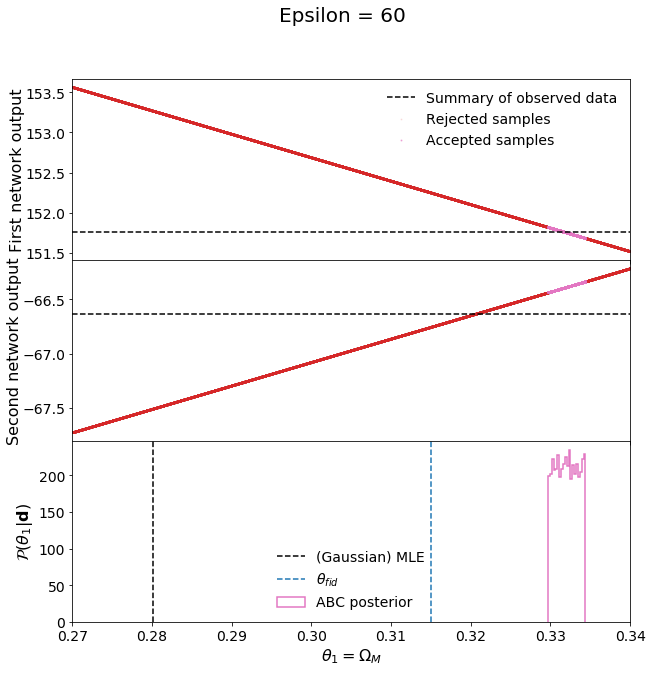

In [41]:
abc_model1D = ABC_with_model1D(draws, real_summary, prior, model11, model21, fisher)
abc_model1D["MLE"] = abc["MLE"][:,0] # only 1st param
plot_1D(abc_model1D, prior, epsilon=60,analytic_posterior = None, param_array = None)